In [1]:
"""
    Install python packages.
    You might see an error like this:

    ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
    flask 2.2.4 requires click>=8.0, but you have click 7.1.2 which is incompatible.
    pip-tools 6.13.0 requires click>=8, but you have click 7.1.2 which is incompatible.

    You can ignore it, everything works without click.
"""
!pip -q install spleeter ipython soundfile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.2/51.2 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.8/203.8 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [97]:
"""
    Connect to the Google Drive so we can load our songs
"""
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
"""
    Basic Imports
"""

"""
    Spleeter
"""
import spleeter
from spleeter.separator import Separator
from spleeter.audio.adapter import AudioAdapter

"""
    Audio manipulations
"""
import librosa
import soundfile as sf

"""
    Calculations
"""
import numpy as np
import scipy
from scipy.signal import convolve

"""
    Fancy graphs and diagrams
"""
import librosa.display
from IPython.display import Audio
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

"""
    Colab
"""
from google.colab import files

In [98]:
"""
    Helper functions
"""

"""
    Visualize audio as a spectrogam
"""
def visualize_spectrogram(audio, sr=44100):
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.tight_layout()
    plt.show()


"""
    Cut track in order to speed up separation and post-processing
"""
def cut(audio, sr=42100):
    return audio[sr*25:sr*80]

"""
    Get mono version of a stereo audio
"""
def mono(audio):
    if len(audio.shape) == 2:
        return audio.mean(axis=1)
    else:
        return audio

In [99]:
"""
    Load and cut songs
    Make sure to adjust acc_path and vocal_path.
"""

acc_path = '/content/drive/My Drive/songs/song2.mp3'
vocal_path = '/content/drive/My Drive/songs/song5.mp3'

separator = Separator('spleeter:4stems', stft_backend=spleeter.audio.STFTBackend.LIBROSA)

"""
    Sample Rate (SR) describes quality of an audio.
    Smaller values will result in better processing speed,
    accuracy of the spleeter worsens though.
"""
sr = 44100


audio_loader = AudioAdapter.default()
acc_unseparated, _ = audio_loader.load(acc_path, sample_rate=sr)
vocal_unseparated, _ = audio_loader.load(vocal_path, sample_rate=sr)

"""
    Used for speeding the things up when testing.
"""
acc_unseparated = cut(acc_unseparated)
vocal_unseparated = cut(vocal_unseparated)

In [100]:
"""
    Separate vocals and accompaniment using Spleeter
"""

vocal_separated = separator.separate(vocal_unseparated)
acc_separated = separator.separate(acc_unseparated)

In [101]:
"""
    Make the audio mono for further processing.
    We should also transpose it for further processing with librosa.
"""

vocal = mono(vocal_separated['vocals']).T
vocal_unseparated = mono(vocal_unseparated).T

acc = mono(acc_separated['other'] + acc_separated['drums'] + acc_separated['bass']).T
acc_unseparated = mono(acc_unseparated).T

In [102]:
"""
    Normalize the loudness of the vocal track based on the accompaniment track.
"""

def normalize_loudness(acc, vocal, frame_length=512, hop_length=512):

    # Make a copy of the vocal track to avoid modifying the original
    vocal_normalized = vocal.copy()

    loudness = {}

    # Calculate the root mean square (loudness) for each frame
    acc_loudness = librosa.feature.rms(acc, frame_length=frame_length, hop_length=hop_length)[0]
    vocal_loudness = librosa.feature.rms(vocal_normalized, frame_length=frame_length, hop_length=hop_length)[0]

    loudness['acc'] = acc_loudness
    loudness['vocal'] = vocal_loudness

    vocal_normalized = vocal_normalized * acc_loudness.mean() / vocal_loudness.mean()

    # Adjust the loudness of each frame of the vocal track based on the accompaniment
    """
    for i, (a, v) in enumerate(zip(acc_loudness, vocal_loudness)):
        l = i * hop_length
        r = (i + 1) * hop_length
        ratio = a / v
        vocal_normalized[l:r] *= ratio
    """
    loudness['normalized'] = librosa.feature.rms(vocal_normalized, frame_length=frame_length, hop_length=hop_length)[0]

    return vocal_normalized, loudness

In [103]:
"""
    Aligns the beats of vocals and accompaniment to the same beat structure.
"""

def align_beat(vocal, vocal_unseparated, acc, acc_unseparated, sr=44100, hop_length=1024, verbose=False):
    def beat(song):
        return librosa.beat.beat_track(y=song, sr=sr, hop_length=hop_length, units='samples')

    def calc_stretch(beat_times_from, beat_times_to):
        return ((beat_times_to[1:] - beat_times_to[:-1]).mean() /
                (beat_times_from[1:] - beat_times_from[:-1]).mean())

    def stretch(song, mult):
        return librosa.effects.time_stretch(song, mult)

    def process(song, unseparated, other_unseparated, mult):
        song_unseparated_speedup = stretch(unseparated, mult)
        song_speedup = stretch(song, mult)

        _, beat_samples_song_speedup = beat(song_unseparated_speedup)
        _, beat_samples_other_speedup = beat(other_unseparated)

        shift = beat_samples_song_speedup[1] - beat_samples_other_speedup[0]
        song_speedup_shifted = song_speedup[shift if shift >= 0 else 0:]

        return song_speedup_shifted

    # Detect the bpm in each track
    tempo_vocal, beat_samples_vocal = beat(vocal_unseparated)
    tempo_acc, beat_samples_acc = beat(acc_unseparated)

    if verbose: print(f'Detected bpms:\nVocal - {tempo_vocal}\nAcc   - {tempo_acc}')

    # Calculate the necessary time stretch to align them
    mult = calc_stretch(beat_samples_vocal, beat_samples_acc)
    mult_vocal = 1. / (mult ** 0.5)
    mult_acc = mult ** 0.5

    if verbose: print(f'Detected bpm ratio: {mult}\nSpeeding up vocal by {mult_vocal}\nSpeeding up acc by   {mult_acc}')

    # Shift tracks as their lenght changes after speeding up (slowing down)
    vocal_speedup_shifted = process(vocal, vocal_unseparated, acc_unseparated, mult_vocal)
    acc_speedup_shifted = process(acc, acc_unseparated, vocal_unseparated, mult_acc)

    common_length = min(acc_speedup_shifted.shape[0], vocal_speedup_shifted.shape[0])

    return acc_speedup_shifted[:common_length],  vocal_speedup_shifted[:common_length]


In [104]:
"""
    Denoise audio using STFT
"""

def denoise(audio, sr=44100, hop_length=1024, n_fft=2048, top_db=20):
    stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    mask = np.abs(stft) > librosa.power_to_db(top_db)
    stft_denoised = mask * stft
    audio_denoised = librosa.istft(stft_denoised, hop_length=hop_length)

    return audio_denoised

In [105]:
"""
    Actually run normalizing and beat alignment.
"""

vocal_normalized, loudness = normalize_loudness(acc, vocal, frame_length=512, hop_length=512)

acc_adjusted, vocal_adjusted = align_beat(
    vocal,
    vocal_unseparated,
    acc,
    acc_unseparated,
    verbose=True
)

merged = acc_adjusted * 0.8 + vocal_adjusted

#denoised = denoise(merged)

Detected bpms:
Vocal - 99.38401442307692
Acc   - 117.45383522727273
Detected bpm ratio: 0.812380691459276
Speeding up vocal by 1.109481854309365
Speeding up acc by   0.9013216359653617


In [106]:
"""
    Play the merged song!
"""
Audio(data=merged, rate=sr)

In [109]:
"""
    Save merged song
"""

# Save the waveform as a WAV file
sf.write('merged.wav', merged, sr)
files.download('merged.wav')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

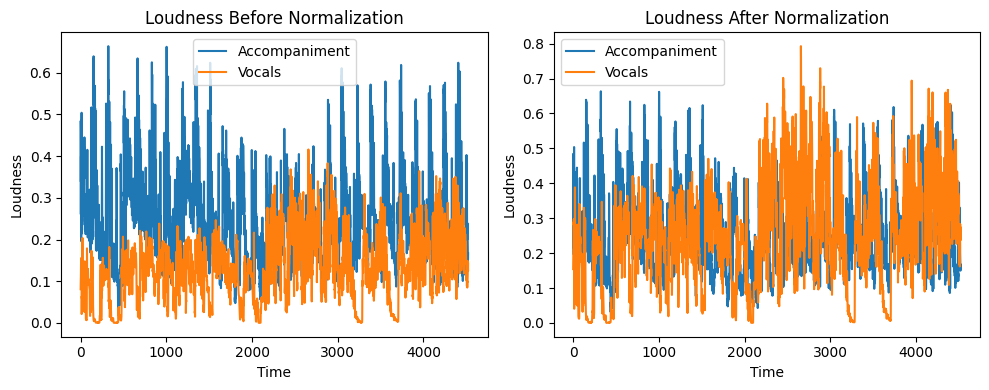

In [108]:
"""
    Plot loudness before and after normalization
"""

# Create a subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot loudness of accompaniment and vocals before normalization
axes[0].plot(loudness['acc'], label='Accompaniment')
axes[0].plot(loudness['vocal'], label='Vocals')
axes[0].set_title('Loudness Before Normalization')  # Title of the first plot
axes[0].set_xlabel('Time')  # X-axis label of the first plot
axes[0].set_ylabel('Loudness')  # Y-axis label of the first plot
axes[0].legend()  # Display legend

# Plot loudness of accompaniment and vocals after normalization
axes[1].plot(loudness['acc'], label='Accompaniment')
axes[1].plot(loudness['normalized'], label='Vocals')
axes[1].set_title('Loudness After Normalization')  # Title of the second plot
axes[1].set_xlabel('Time')  # X-axis label of the second plot
axes[1].set_ylabel('Loudness')  # Y-axis label of the second plot
axes[1].legend()  # Display legend

# Arrange the layout so that plots do not overlap
plt.tight_layout()
plt.show()


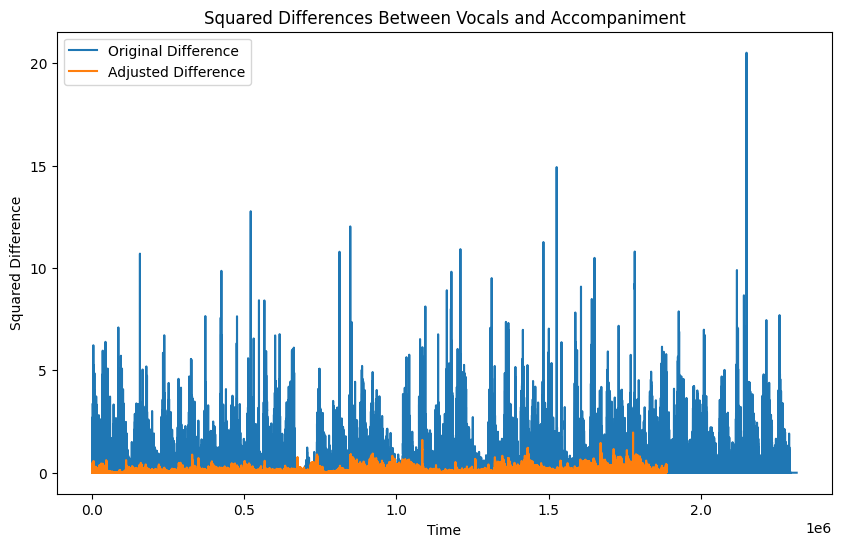

In [ ]:
"""
    Plot vocal and accompaniment L2 difference before and after beat alingment
"""

plt.figure(figsize=(10, 6))

plt.plot((acc - vocal_normalized) ** 2, label='Original Difference')
plt.plot((acc_adjusted - vocal_adjusted) ** 2, label='Adjusted Difference')

plt.title('Squared Differences Between Vocals and Accompaniment')  # Title of the plot
plt.xlabel('Time')  # X-axis label
plt.ylabel('Squared Difference')  # Y-axis label
plt.legend()  # Display legend
plt.show()

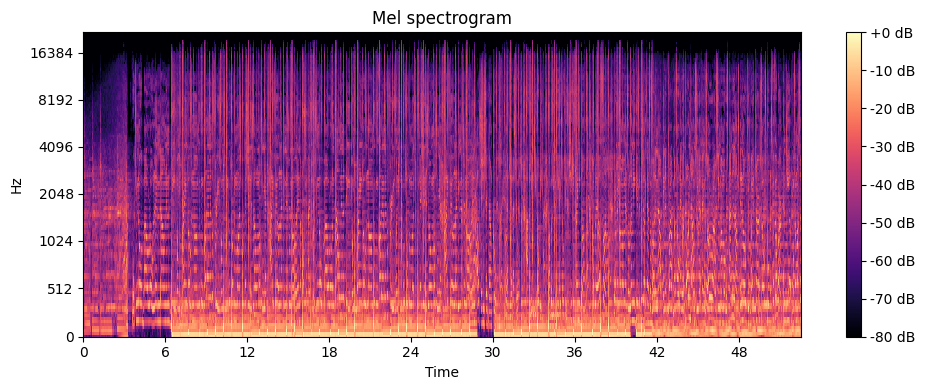

In [ ]:
S = librosa.feature.melspectrogram(y=vocal_unseparated, sr=sr, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.title('Mel spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()
plt.show()
